In [1]:
# Importing the libraries
import sys
import os
import json
import pandas
import numpy
import optparse
from keras.callbacks import TensorBoard
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Dropout, SimpleRNN
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.optimizers import SGD
from collections import OrderedDict
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [2]:
# importing the data

dataframe = pandas.read_csv("dev-access.csv", engine='python', quotechar='|', header=None)

In [3]:
#  converting to numpy array

dataset = dataframe.values

In [4]:
#  Checking the shape of the data set 

dataset.shape

(26773, 2)

In [5]:
# Storing all rows and the 0th index as the feature data: 
X = dataset[:,0]

In [6]:
#  Storing all rows and index 1 as the target variable: 
y =dataset[:,1]

In [7]:
# Cleaning up the predictors.

for index, item in enumerate(X):
    # Quick hack to space out json elements
    reqJson = json.loads(item, object_pairs_hook=OrderedDict)
    del reqJson['timestamp']
    del reqJson['headers']
    del reqJson['source']
    del reqJson['route']
    del reqJson['responsePayload']
    X[index] = json.dumps(reqJson, separators=(',', ':'))

In [8]:
# Tokenize our data

tokenizer = Tokenizer(filters='\t\n', char_level=True)
tokenizer.fit_on_texts(X)

# we will need this later
num_words = len(tokenizer.word_index)+1
X = tokenizer.texts_to_sequences(X)

In [9]:
# Pad our data 

max_log_length = 1024
X_processed = sequence.pad_sequences(X, maxlen=max_log_length)

In [10]:
# Create the train set to be 75% of the data and the test set to be 25%

X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size =0.25, random_state = 1)

## 2. Model 1 - RNN:

The first model will be a pretty minimal RNN with only an embedding layer, simple RNN and Dense layer. The next model we will add a few more layers. 
Starting by creating an instance of a Sequential model: https://keras.io/getting-started/sequential-model-guide/

In [11]:
model1 = Sequential()

Then adding an Embedding layer: https://keras.io/layers/embeddings/ (Links to an external site.)

Params:
- input_dim = num_words (the variable we created above)
- output_dim = 32
- input_length = max_log_length (we also created this above)
- Keep all other variables as the defaults (shown below)

In [12]:
model1.add(Embedding(num_words, 32, input_length = max_log_length))

Adding a SimpleRNN layer: https://keras.io/layers/recurrent/ (Links to an external site.)

Params:
- units = 32
- activation = 'relu'

In [13]:
model1.add(SimpleRNN(units = 32, activation="relu"))


adding a Dense layer: https://keras.io/layers/core/#dense (Links to an external site.)

Params:
- units = 1 (this will be our output)
- activation --> you can choose to use either relu or sigmoid. 

In [14]:
model1.add(Dense(1, activation="relu"))

Compiling model using the .compile() method: https://keras.io/models/model/ (Links to an external site.)

Params:
- loss = binary_crossentropy
- optimizer = adam
- metrics = accuracy

In [15]:
model1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'] )

Printing the model summary

In [16]:
model1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 1024, 32)          2016      
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 32)                2080      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 4,129
Trainable params: 4,129
Non-trainable params: 0
_________________________________________________________________


In [19]:
from keras.utils import plot_model
import matplotlib.pyplot as plt

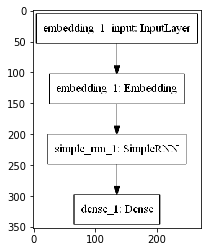

In [20]:
# Plot the model
plot_model(model1, to_file='model1.png')

# Display the image
data = plt.imread('model1.png')
plt.imshow(data)
plt.show()

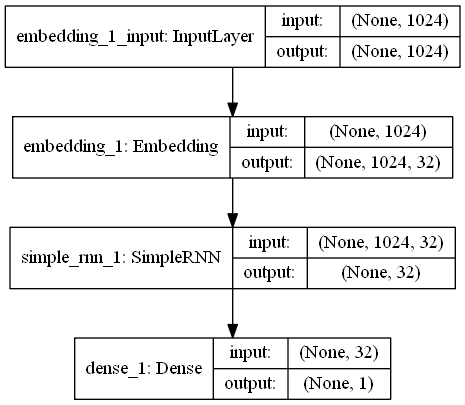

In [23]:
plot_model(model1, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

Using the .fit() method to fit the model on the train data. Use a validation split of 0.25, epochs=3 and batch size = 128.

In [18]:
from keras.utils import plot_model
import matplotlib.pyplot as plt

In [17]:
model1.fit(X_train, y_train, validation_split=0.25, epochs=3, batch_size=128)

C:\Users\Gokturk\Anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 15059 samples, validate on 5020 samples
Epoch 1/3
 6656/15059 [============>.................] - ETA: 44s - loss: 7.6893 - accuracy: 0.5015

KeyboardInterrupt: 

Using the .evaluate() method to get the loss value & the accuracy value on the test data. Using a batch size of 128 again.

In [47]:
model1.evaluate(X_test, y_test, batch_size=128, verbose=1)

6694/6694 [==============================] - 3s 464us/step


[0.14148185185115303, 0.5301762819290161]

##  Model 2 - LSTM + Dropout Layers:

Adding a few new layers to the RNN and incorporate the more powerful LSTM. 

with the following layers :
- Embedding Layer (using same params as before)
- LSTM Layer (units = 64, recurrent_dropout = 0.5)
- Dropout Layer - using a value of 0.5
- Dense Layer - (using same params as before)

In [48]:
model2 = Sequential()
model2.add(Embedding(num_words, 32, input_length = max_log_length))
model2.add(LSTM(units = 64, recurrent_dropout=0.5))
model2.add(Dropout(0.5))
model2.add(Dense(1, activation="relu"))

Compiling model using the .compile() method:

Params:
- loss = binary_crossentropy
- optimizer = adam
- metrics = accuracy

In [49]:
model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'] )

Printing the model summary

In [50]:
model2.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 1024, 32)          2016      
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                24832     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
Total params: 26,913
Trainable params: 26,913
Non-trainable params: 0
_________________________________________________________________


Using the .fit() method to fit the model on the train data. Using a validation split of 0.25, epochs=3 and batch size = 128.

In [51]:
model2.fit(X_train, y_train, validation_split=0.25, epochs=3, batch_size=128)

C:\Users\Gokturk\Anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 15059 samples, validate on 5020 samples
Epoch 1/3
15059/15059 [==============================] - 253s 17ms/step - loss: 0.7919 - accuracy: 0.5268 - val_loss: 0.6290 - val_accuracy: 0.6313
Epoch 2/3
15059/15059 [==============================] - 272s 18ms/step - loss: 0.6231 - accuracy: 0.5961 - val_loss: 0.5635 - val_accuracy: 0.5775
Epoch 3/3
15059/15059 [==============================] - 273s 18ms/step - loss: 0.6063 - accuracy: 0.5779 - val_loss: 0.4156 - val_accuracy: 0.5259


Using the .evaluate() method to get the loss value & the accuracy value on the test data. Using a batch size of 128 again.

In [52]:
model2.evaluate(X_test, y_test, batch_size=128, verbose=1)

6694/6694 [==============================] - 30s 4ms/step


[0.42150654680949023, 0.5319689512252808]

##  Recurrent Neural Net Model 3



In [54]:
model3 = Sequential()
model3.add(Embedding(num_words, 32, input_length=max_log_length))
model3.add(Dropout(0.5))
model3.add(LSTM(units = 64, recurrent_dropout=0.5))
model3.add(Dense(64, activation='tanh'))
model3.add(Dropout(0.2))
model3.add(Dense(1, activation='sigmoid'))

In [55]:
model3.compile(loss='binary_crossentropy', optimizer='Adagrad',metrics=['accuracy'])

Printing the model summary

In [56]:
model3.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 1024, 32)          2016      
_________________________________________________________________
dropout_4 (Dropout)          (None, 1024, 32)          0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                24832     
_________________________________________________________________
dense_7 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 65        
Total params: 31,073
Trainable params: 31,073
Non-trainable params: 0
__________________________________________________

Using the .fit() method to fit the model on the train data. Use a validation split of 0.25, epochs=3 and batch size = 128.

In [57]:
model3.fit(X_train, y_train, validation_split=0.25, epochs=3, batch_size=128) 

C:\Users\Gokturk\Anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 15059 samples, validate on 5020 samples
Epoch 1/3
15059/15059 [==============================] - 511s 34ms/step - loss: 0.5629 - accuracy: 0.6909 - val_loss: 0.5321 - val_accuracy: 0.7096
Epoch 2/3
15059/15059 [==============================] - 494s 33ms/step - loss: 0.3284 - accuracy: 0.8803 - val_loss: 0.1642 - val_accuracy: 0.9620
Epoch 3/3
15059/15059 [==============================] - 531s 35ms/step - loss: 0.2246 - accuracy: 0.9340 - val_loss: 0.3544 - val_accuracy: 0.8723


Using the .evaluate() method to get the loss value & the accuracy value on the test data. Use a batch size of 128 .

In [58]:
model3.evaluate(x=X_test, y=y_test, batch_size=128, verbose=1)

6694/6694 [==============================] - 36s 5ms/step


[0.3527716842469152, 0.8716761469841003]